# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram
import pop_tools
import xesmf as xe

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

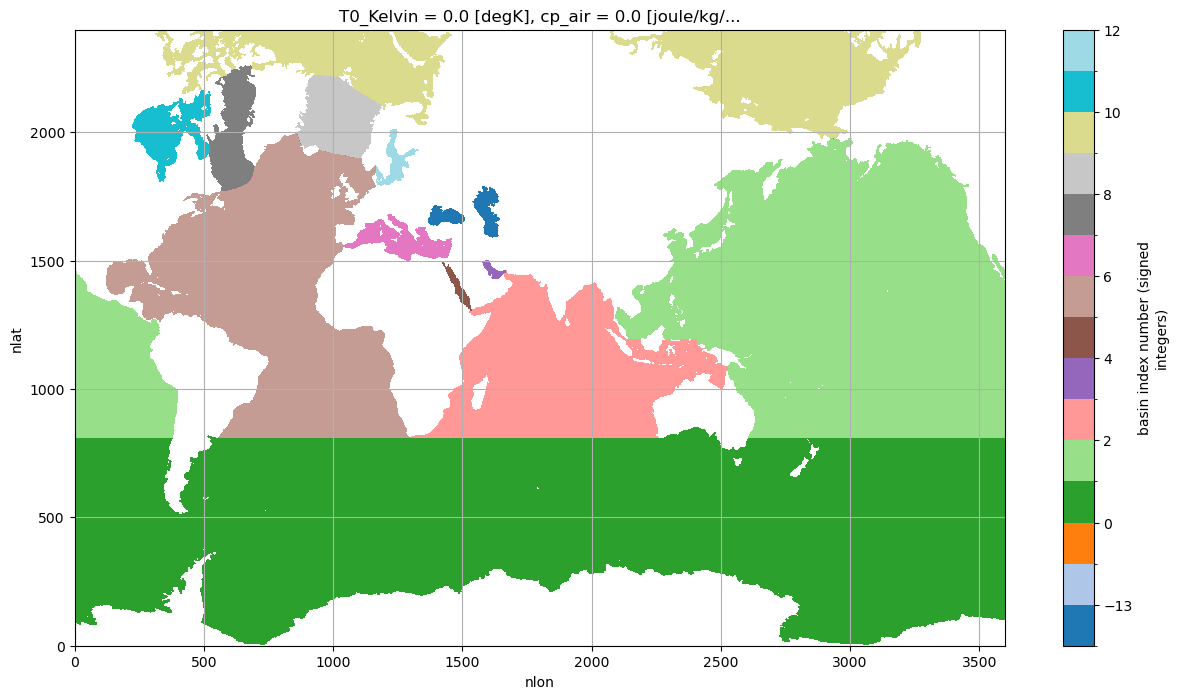

In [6]:
#to know which region index value is what basin
plt.figure(figsize=(15,8))
regions = np.unique(ds.REGION_MASK)
ds.REGION_MASK.where(ds.KMT>0).plot.contourf(levels=regions, cmap='tab20')
plt.grid();

In [7]:
regions

array([-14., -13.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.])

In [8]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

# Split the tendencies by basin

In [9]:
all_tendencies = list(tendencies)

In [10]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [11]:
#Atlantic Ocean
atl_ocean = xr.merge([basin_selection(tendencies[var], atlantic_ocean).rename('ATL_' + var) for var in all_tendencies])

#Pacific Ocean
pac_ocean = xr.merge([basin_selection(tendencies[var], pacific_ocean).rename('PAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tendencies[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tendencies[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tendencies[var], southern_ocean).rename('South_' + var) for var in all_tendencies])

## Compute histogram by basin

In [12]:
#New ds after dthetadt*drhodt and dSdt*drhods

atl_tend = xr.merge([(atl_ocean.ATL_SST_bih*atl_ocean.ATL_drhodt).rename('ATL_sst'), 
          (atl_ocean.ATL_SSS_bih*atl_ocean.ATL_drhods).rename('ATL_sss'), 
          atl_ocean.ATL_rho_bih.rename('ATL_rho'), 
          atl_ocean.ATL_cabbeling.rename('ATL_cabbeling')])

pac_tend = xr.merge([(pac_ocean.PAC_SST_bih*pac_ocean.PAC_drhodt).rename('PAC_sst'), 
          (pac_ocean.PAC_SSS_bih*pac_ocean.PAC_drhods).rename('PAC_sss'), 
          pac_ocean.PAC_rho_bih.rename('PAC_rho'), 
          pac_ocean.PAC_cabbeling.rename('PAC_cabbeling')])

ind_tend = xr.merge([(ind_ocean.IND_SST_bih*ind_ocean.IND_drhodt).rename('IND_sst'), 
          (ind_ocean.IND_SSS_bih*ind_ocean.IND_drhods).rename('IND_sss'), 
          ind_ocean.IND_rho_bih.rename('IND_rho'), 
          ind_ocean.IND_cabbeling.rename('IND_cabbeling')])

arc_tend = xr.merge([(arc_ocean.ARC_SST_bih*arc_ocean.ARC_drhodt).rename('ARC_sst'), 
          (arc_ocean.ARC_SSS_bih*arc_ocean.ARC_drhods).rename('ARC_sss'), 
          arc_ocean.ARC_rho_bih.rename('ARC_rho'), 
          arc_ocean.ARC_cabbeling.rename('ARC_cabbeling')])

south_tend = xr.merge([(south_ocean.South_SST_bih*south_ocean.South_drhodt).rename('South_sst'), 
          (south_ocean.South_SSS_bih*south_ocean.South_drhods).rename('South_sss'), 
          south_ocean.South_rho_bih.rename('South_rho'), 
          south_ocean.South_cabbeling.rename('South_cabbeling')])

In [13]:
atl_tendencies = list(atl_tend)
pac_tendencies = list(pac_tend)
ind_tendencies = list(ind_tend)
arc_tendencies = list(arc_tend)
south_tendencies = list(south_tend)

In [14]:
rho = fastjmd95.rho(ds.SSS, ds.SST, 0)
#rho = rho_unsliced.isel(time=slice(0,182))

In [15]:
#area = ds.TAREA * ds.dz * 1e-4 #convert cm^2 to m^2
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [16]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(variable.fillna(0.)*ds.TAREA), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [27]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [28]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.92ab90296a804994bf1c85c36fa3ecea/status,


In [23]:
client.close()
cluster.close()

In [29]:
atl_histograms = xr.merge([histogram_func(atl_tend[var]).rename('OMEGA_' + var)
                      for var in atl_tendencies])
pac_histograms = xr.merge([histogram_func(pac_tend[var]).rename('OMEGA_' + var)
                      for var in pac_tendencies])
ind_histograms = xr.merge([histogram_func(ind_tend[var]).rename('OMEGA_' + var)
                      for var in ind_tendencies])
arc_histograms = xr.merge([histogram_func(arc_tend[var]).rename('OMEGA_' + var)
                      for var in arc_tendencies])
south_histograms = xr.merge([histogram_func(south_tend[var]).rename('OMEGA_' + var)
                      for var in south_tendencies])

In [30]:
atl_histograms

<xarray.Dataset>
Dimensions:              (time: 14965, rho0_bin: 1499)
Coordinates:
  * time                 (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:...
  * rho0_bin             (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_ATL_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_ATL_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_ATL_rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_ATL_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

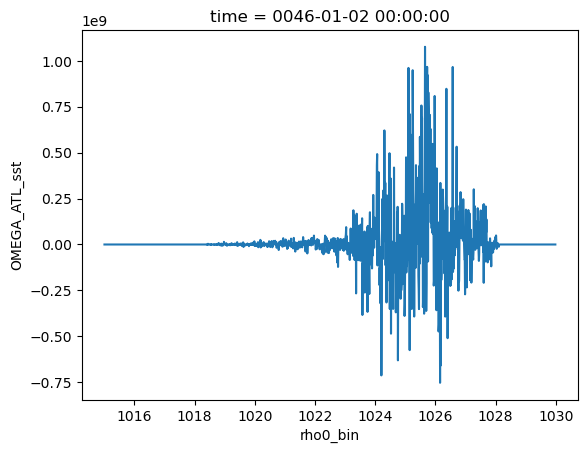

In [31]:
atl_histograms.OMEGA_ATL_sst[0].plot()

In [32]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.92ab90296a804994bf1c85c36fa3ecea/status,


# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [33]:
#saving atlantic basin histograms
gcsmap_hist_atl = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/atl_histograms.zarr')
atl_histograms.to_zarr(gcsmap_hist_atl, mode='w')

In [ ]:
#saving pacific basin histograms
gcsmap_hist_atl = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/pac_histograms.zarr')
pac_histograms.to_zarr(gcsmap_hist_pac, mode='w')

In [ ]:
#saving indian basin histograms
gcsmap_hist_ind = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/ind_histograms.zarr')
ind_histograms.to_zarr(gcsmap_hist_ind, mode='w')

In [ ]:
#saving arctic basin histograms
gcsmap_hist_arc = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/arc_histograms.zarr')
arc_histograms.to_zarr(gcsmap_hist_arc, mode='w')

In [ ]:
#saving southern basin histograms
gcsmap_hist_south = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/south_histograms.zarr')
south_histograms.to_zarr(gcsmap_hist_south, mode='w')

[Back to top](#top)